<a href="https://colab.research.google.com/github/brian-lear/bootcamp_alura/blob/main/Brian_Lear_Projeto_M%C3%B3dulo_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instruções

Olá **Cientista**!

Bem vinda e bem vindo ao **projeto do Módulo 02**, neste desafio queremos que você aplique tudo que aprendeu no módulo 1 e 2, analisando dados do [programa de imunização nacional](http://tabnet.datasus.gov.br/cgi/tabcgi.exe?pni/cnv/cpniuf.def), você pode analisar dados de **imunos** escolhidos por você, pode analisar toda a base de dados, apenas do seu estado ou de estados específicos. Pode analisar as taxas a cobertura ou doses calculadas, buscar outras fontes de informações fora do data SUS, como também, usar outros dados do DataSUS para enriquecer suas análises. 



Algumas dicas para você mandar bem no desafio final, capriche nas análises, escreva suas conclusões e hipóteses (mesmo que resultado seja inconclusivo) e não esqueça de colocar um resumo dos pontos que julgar mais interessantes do seu projeto.

**P.S: Vamos agendar um cafezinho para discutir o módulo 2, fique atento para os aviso no DISCORD**

E para que o seu projeto tenha a oportunidade de ser avalido pelo Thiago G. Santos e Átila Iamarino, ao vivo na **live de revisão de projetos** submeta o link compartilhado do seu notebook até dia 06/12 às 23h59 neste [formulário](https://forms.gle/HNR6yen2xB5ttv7D6).

Para facilitar a vida dos seus instrutores favoritos, no momento da correção, algumas dicas de como estruturar seu projeto:

- Como título do seu **Colab** coloque seu nome (Ex: Thiago_Gonçalves.ipynb)
- Crie um resumo das suas análises na parte superior do notebook
- Informe no resumo os dados que vc vai analisar (Ex: Finaceiros e Internações)

Qualquer dúvida não deixe de perguntar no Discord, compatilhe seu projeto nas redes sociais e crie um repositório no github, esse é o início do seu portifólio em Data Science.



Fique a vontade para utilizar esse notebook como template projeto.



# **Análise histórica da incidência do Sarampo e a relação dos casos com a cobertura vacinal**

## Apresentação

Meu nome é Brian Lear, comecei recentemente minha carreira em Data Science na Loft, uma proptech, como Decision Scientist, focado em levar uma melhor experiência para quem quer vender na nossa plataforma. Antes disso, ocupava um cargo na área de Analytics, ajudando a estruturar bases de dados e disponibilizando-as a outros Lofters para que tenham decisões mais data driven.

- [LinkedIn](https://www.linkedin.com/in/brian-lear-155bb745/)
- [GitHub](https://github.com/brian-lear)

## Contexto

O sarampo é uma doença que assolou por muito tempo o Brasil, mas que também é uma história de sucesso quando pensamos na eficácia das campanhas de vacinação. Através de campanhas bem sucedidas, os casos de sarampo foram praticamente zerados por mais de uma década. Porém, com a queda da cobertura vacinal para abaixo do patamar de 95%, considerado como o ideal, o número de casos tem aumentado, e agora o Brasil se depara com mais um surto, iniciado em 2018.

O escopo da análise é entender como os casos de sarampo oscilaram ao longo dos anos, tanto do ponto de vista nacional como do ponto de vista dos Estados mais afetados pelo sarampo, e verificar a existência de uma relação entre a cobertura vacinal e o número de casos.


---



***Fontes:*** Este estudo utiliza majoritariamente dados extraídos dos DataSUS, através do TABNET, e fontes adicionais de artigos, boletins do Ministério da Saúde e notícias. 

  Para podermos analisar de forma mais equânime os estados, o número de casos foi normalizado pela população de cada estado, virando um novo indicador, **casos por milhão de habitantes**.



> Quanto à cobertura vacinal, segue a definição das [Notas Técnicas do Ministério da Saúde sobre Imunizações](http://tabnet.datasus.gov.br/cgi/pni/Imun_cobertura_desde_1994.pdf):

  *A fórmula de cálculo da cobertura é o número de doses aplicadas da dose indicada (1ª, 2ª, 3ª dose ou dose única, conforme a vacina) dividida
pela população alvo, multiplicado por 100. Exemplo: para a Tetravalente (DTP/Hib), considera-se o número de terceiras doses aplicadas na faixa
etária de menores de 1 ano. Para a vacina oral de rotavírus humano, pode-se avaliar cobertura de 1ª e 2ª doses.*


> Para o caso do sarampo, foi utilizada a cobertura vacinal da vacina Monovalente, da Tríplice Viral D1 (SCR - sarampo/ caxumba/ rubéola) e a Tetra Viral(SRC+VZ) conjuntamente. Isso é explicado no mesmo documento citado acima:


*Para cálculo de coberturas vacinais por tipo de doença, deve-se somar as doses (dose única ou 3ª dose) das vacinas com os referidos
componentes. Exemplo: para a cobertura vacinal contra sarampo, deve-se somar as doses aplicadas (1ª dose) das vacinas tríplice viral,
dupla viral e sarampo monovalente.*

## Manipulando os dados

### Importando Libs

In [296]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [297]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm

### Dados População 2019

In [298]:
df_pop = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/estimativa_dou_2020.csv',thousands='.',decimal=',')
df_pop = df_pop.drop(columns=['Unnamed: 2'])
df_pop.index = df_pop['UF']
df_pop = df_pop.sort_values('Pop',ascending=False)
df_pop = df_pop.drop(columns=['UF'])
df_pop.head()

,Pop
UF,
São Paulo,46289333
Minas Gerais,21292666
Rio de Janeiro,17366189
Bahia,14930634
Paraná,11516840


### % Cobertura Vacina

Para tratar dados errados, ou seja, coberturas acima de 100%, trunquei elas em 100% para facilitar a análise. Considerei elas um erro baseado no trecho encontrado em um [documento do Ministério da Saúde](http://tabnet.datasus.gov.br/tabdata/livroidb/Com2007/Com_F13.pdf):

*É importante ressaltar que altas coberturas vacinais, são também influenciadas pelo denominador. Um
exemplo é onde a base de cálculo é o SINASC e este sistema de informação não apresenta boa
cobertura (maior ou igual a 90% dos nascimentos estimados), ou quando as estimativas populacionais
estão subdimensionadas, ou ainda pela superenumeração do numerador (erros de registros elevando o
número de doses aplicadas).*

In [299]:
df_sarampo_cob = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/imuno_sarampo_cobertura.csv',sep = ';',encoding='ISO-8859-1',skiprows=4,skipfooter=20,decimal=',')

df_sarampo_cob.index = df_sarampo_cob['Unidade da Federação']
df_sarampo_cob = df_sarampo_cob.drop(columns=['Unidade da Federação','Total'])
df_sarampo_cob = df_sarampo_cob.replace('-',0)
df_sarampo_cob = df_sarampo_cob.replace('...',0)
df_sarampo_cob = df_sarampo_cob.apply(pd.to_numeric, errors='coerce')

index_list = df_sarampo_cob.index.str[3:]
df_sarampo_cob.index = index_list

# truncando coberturas maiores que 100% em 100%
for x in df_sarampo_cob.columns:
  a = np.array(df_sarampo_cob[x].values.tolist())
  df_sarampo_cob[x] = np.where(a > 100.0, 100.0, a).tolist()

df_sarampo_cob.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Unidade da Federação,,,,,,,,,,,,,,,,,,,,,,,,,,
Rondônia,75.57,96.54,82.64,100.00,100.00,97.87,59.03,98.62,95.55,61.38,100.0,100.00,100.00,100.0,100.00,100.0,100.00,100.0,100.00,72.41,100.00,100.00,100.00,92.07,77.87,51.24
Acre,37.05,98.03,54.94,93.04,68.15,74.42,60.88,82.16,91.94,49.48,100.0,95.12,90.84,100.0,94.17,100.0,96.87,100.0,90.28,53.92,79.25,66.76,70.08,67.71,71.08,47.95


Como os dados de 2019 estavam incompletos, fiz uma média móvel dos últimos 3 anos para substituir 2019, e para 2020, uma média móvel com memória mais curta, de 2 anos.

In [300]:
df_sarampo_cob_t = df_sarampo_cob.copy()
df_sarampo_cob_t = df_sarampo_cob_t.T

aaa = df_sarampo_cob_t.rolling(window=3).mean()
aaa = aaa[-1:]
aaa = aaa.values[0].tolist()
df_sarampo_cob_t.loc['2019'] = aaa

bbb = df_sarampo_cob_t.rolling(window=2).mean()
bbb = bbb[-1:]
bbb = bbb.values[0].tolist()
df_sarampo_cob_t.loc['2020'] = bbb

df_sarampo_cob = df_sarampo_cob_t.T
df_sarampo_cob.head(2)

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Unidade da Federação,,,,,,,,,,,,,,,,,,,,,,,,,,,
Rondônia,75.57,96.54,82.64,100.00,100.00,97.87,59.03,98.62,95.55,61.38,100.0,100.00,100.00,100.0,100.00,100.0,100.00,100.0,100.00,72.41,100.00,100.00,100.00,92.07,77.87,73.726667,75.798333
Acre,37.05,98.03,54.94,93.04,68.15,74.42,60.88,82.16,91.94,49.48,100.0,95.12,90.84,100.0,94.17,100.0,96.87,100.0,90.28,53.92,79.25,66.76,70.08,67.71,71.08,62.246667,66.663333


Fiz a mesma lógica pensando na cobertura Nacional e por região

In [301]:
df_sarampo_cob_nac = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/imuno_sarampo_cobertura_nacional.csv',sep = ';',encoding='ISO-8859-1',skiprows=4,skipfooter=19,decimal=',')
df_sarampo_cob_nac.loc[df_sarampo_cob_nac['Região']=='Total','Região'] = '0 Total'
df_sarampo_cob_nac.index = df_sarampo_cob_nac['Região']
df_sarampo_cob_nac = df_sarampo_cob_nac.drop(columns=['Região','Total'])
df_sarampo_cob_nac = df_sarampo_cob_nac.replace('-',0)
df_sarampo_cob_nac = df_sarampo_cob_nac.replace('...',0)
df_sarampo_cob_nac = df_sarampo_cob_nac.apply(pd.to_numeric, errors='coerce')

index_list = df_sarampo_cob_nac.index.str[2:]
new_index = []

# Eliminando a palavra Região do index
for x in index_list:
  y = x.replace('Região ','')  
  new_index.append(y)
df_sarampo_cob_nac.index = new_index

# truncando coberturas maiores que 100% em 100%
for x in df_sarampo_cob_nac.columns:
  a = np.array(df_sarampo_cob_nac[x].values.tolist())
  df_sarampo_cob_nac[x] = np.where(a > 100.0, 100.0, a).tolist()

df_sarampo_cob_nac.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Norte,57.45,88.60,66.23,100.00,72.89,87.7,61.51,84.35,100.00,57.61,100.00,100.0,100.0,100.0,100.00,100.00,100.00,100.00,100.00,62.17,94.78,71.81,76.69,70.58,69.06,46.48
Nordeste,76.54,81.35,73.29,100.00,89.18,100.0,85.53,96.59,95.73,59.67,100.00,100.0,100.0,100.0,100.00,100.00,100.00,100.00,98.38,71.61,100.00,86.18,81.70,59.01,51.50,30.70
Sudeste,96.21,93.85,91.28,100.00,100.00,100.0,100.00,100.00,97.44,58.85,100.00,100.0,100.0,100.0,97.08,100.00,96.23,100.00,100.00,71.46,100.00,93.45,90.05,56.62,58.78,35.49
Sul,87.35,87.14,87.34,100.00,98.00,100.0,95.80,86.83,95.70,56.96,97.31,100.0,100.0,100.0,95.24,99.08,96.20,97.14,97.00,72.64,99.04,83.40,92.64,80.33,77.95,57.93
Centro-Oeste,50.89,79.58,73.74,83.98,74.78,100.0,89.42,90.48,90.07,57.49,100.00,100.0,100.0,100.0,99.44,100.00,100.00,100.00,100.00,73.68,100.00,80.98,97.38,79.80,79.27,52.84
Total,71.35,86.85,80.39,100.00,95.26,100.0,91.46,96.03,96.47,58.64,100.00,100.0,100.0,100.0,99.81,100.00,99.93,100.00,99.50,70.83,100.00,86.72,87.22,63.85,62.18,39.83


In [302]:
df_sarampo_cob_nac_t = df_sarampo_cob_nac.copy()
df_sarampo_cob_nac_t = df_sarampo_cob_nac_t.T

aaa = df_sarampo_cob_nac_t.rolling(window=3).mean()
aaa = aaa[-1:]
aaa = aaa.values[0].tolist()
df_sarampo_cob_nac_t.loc['2019'] = aaa

bbb = df_sarampo_cob_nac_t.rolling(window=2).mean()
bbb = bbb[-1:]
bbb = bbb.values[0].tolist()
df_sarampo_cob_nac_t.loc['2020'] = bbb

df_sarampo_cob_nac = df_sarampo_cob_nac_t.T
df_sarampo_cob_nac.head(2)

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Norte,57.45,88.60,66.23,100.0,72.89,87.7,61.51,84.35,100.00,57.61,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.00,62.17,94.78,71.81,76.69,70.58,69.06,62.04,65.550
Nordeste,76.54,81.35,73.29,100.0,89.18,100.0,85.53,96.59,95.73,59.67,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,98.38,71.61,100.00,86.18,81.70,59.01,51.50,47.07,49.285


### Doses Vacina

In [303]:
df_sarampo_doses = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/imuno_sarampo_doses.csv',sep = ';',encoding='ISO-8859-1',skiprows=4,skipfooter=20)
df_sarampo_doses.index = df_sarampo_doses['Unidade da Federação']
df_sarampo_doses = df_sarampo_doses.drop(columns=['Unidade da Federação'])
df_sarampo_doses = df_sarampo_doses.replace('-',0)
df_sarampo_doses = df_sarampo_doses.apply(pd.to_numeric, errors='coerce')

index_list = df_sarampo_doses.index.str[3:]
df_sarampo_doses.index = index_list

df_sarampo_doses.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Total
Unidade da Federação,,,,,,,,,,,,,,,,,,,,,,,,,,,
Rondônia,33300,35880,31463,30986,31409,29884,36537,60589,59770,39088,37787,32592,31243,26833,27722,26673,26184,26785,27485,40035,68839,55067,56411,50731,41392,28186,992871
Acre,5111,13442,7658,12023,9049,10149,18539,24747,28260,15745,20211,16428,14939,17711,16941,17438,16330,17749,15219,19190,26440,22718,23928,23117,22368,15686,451136


In [304]:
df_sarampo_doses_t = df_sarampo_doses.copy()
df_sarampo_doses_t = df_sarampo_doses_t.T
df_sarampo_doses_t = df_sarampo_doses_t[:-1]

# média móvel para calcular 2019 e 2020
aaa = df_sarampo_doses_t.rolling(window=3).mean()
aaa = aaa[-1:]
aaa = aaa.values[0].tolist()
df_sarampo_doses_t.loc['2019'] = aaa

bbb = df_sarampo_doses_t.rolling(window=2).mean()
bbb = bbb[-1:]
bbb = bbb.values[0].tolist()
df_sarampo_doses_t.loc['2020'] = bbb

df_sarampo_doses = df_sarampo_doses_t.T

# adicionando a linha 'Total'
df_test = df_sarampo_doses.copy()
total = df_test.sum()
total.name = 'Total'
df_sarampo_doses = df_sarampo_doses.append(total.transpose())

df_sarampo_doses.head(2)

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Unidade da Federação,,,,,,,,,,,,,,,,,,,,,,,,,,,
Rondônia,33300.0,35880.0,31463.0,30986.0,31409.0,29884.0,36537.0,60589.0,59770.0,39088.0,37787.0,32592.0,31243.0,26833.0,27722.0,26673.0,26184.0,26785.0,27485.0,40035.0,68839.0,55067.0,56411.0,50731.0,41392.0,40103.000000,40747.500000
Acre,5111.0,13442.0,7658.0,12023.0,9049.0,10149.0,18539.0,24747.0,28260.0,15745.0,20211.0,16428.0,14939.0,17711.0,16941.0,17438.0,16330.0,17749.0,15219.0,19190.0,26440.0,22718.0,23928.0,23117.0,22368.0,20390.333333,21379.166667


### Casos de Sarampo

Os casos de sarampo não estão todos disponíveis nas tabelas do TABNET, sendo necessária uma busca por outras fontes dessa informação. Com isso, consegui informações de 2018, 2019 e 2020 (parcial, semanas 1-43).

In [305]:
df_sarampo_casos_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/casos_sarampo_1990_2010.csv',sep = ';',encoding='ISO-8859-1',skiprows=3,skipfooter=14)

df_sarampo_casos_1 = df_sarampo_casos_1.replace('-',0)

# adicionando anos faltantes por não terem casos reportados
df_sarampo_casos_1['2004'] = 0
df_sarampo_casos_1['2007'] = 0
df_sarampo_casos_1['2008'] = 0


reord_columns = df_sarampo_casos_1.columns.to_list()
reord_columns = reord_columns[:15]
reord_columns = reord_columns + ['2004','2005','2006','2007','2008','2009','2010']

df_sarampo_casos_1 = df_sarampo_casos_1[reord_columns]
df_sarampo_casos_1.index = df_sarampo_casos_1['Unidade da Federação']
df_sarampo_casos_1 = df_sarampo_casos_1.drop(columns=['Unidade da Federação'])
df_sarampo_casos_1 = df_sarampo_casos_1.apply(pd.to_numeric, errors='coerce')
df_sarampo_casos_1.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
Unidade da Federação,,,,,,,,,,,,,,,,,,,,,
Rondônia,165,211,48,71,35,23,7,17,22,1,0,0,0,0,0,0,0,0,0,0,0
Acre,537,89,40,0,4,8,4,12,9,14,15,0,0,0,0,0,0,0,0,0,0


In [306]:
df_sarampo_casos_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/casos_sarampo_2010_2014.csv',sep = ';',encoding='ISO-8859-1',skiprows=4,skipfooter=20)

df_sarampo_casos_2.index = df_sarampo_casos_2['UF de notificação']
df_sarampo_casos_2 = df_sarampo_casos_2.drop(columns=['UF de notificação','Total','1990','1991','2007','2009','2010'])
df_sarampo_casos_2 = df_sarampo_casos_2.replace('-',0)
df_sarampo_casos_2 = df_sarampo_casos_2.apply(pd.to_numeric, errors='coerce')

index_list = df_sarampo_casos_2.index.str[3:]
df_sarampo_casos_2.index = index_list

df_sarampo_casos_2.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,2011,2012,2013,2014
UF de notificação,,,,
Roraima,0,0,0,3
Pará,0,0,0,0


Adicionei colunas zeradas para 2015, 2016 e 2017 por conta da [ausência de casos](https://www.bbc.com/portuguese/geral-47410826) de sarampo no Brasil nesses anos.

In [307]:
# juntando dfs com dados de 1990 até 2014
df_sarampo_casos = df_sarampo_casos_1.merge(df_sarampo_casos_2,how='left',left_index=True,right_index=True)

# adicionando colunas zeradas para 2015-2017 e colunas vazias para serem populadas de 2018-2020
df_sarampo_casos['2015'] = 0
df_sarampo_casos['2016'] = 0
df_sarampo_casos['2017'] = 0
df_sarampo_casos['2018'] = ''
df_sarampo_casos['2019'] = ''
df_sarampo_casos['2020'] = ''

Casos dos anos de 2018-2020 foram encontrados em outras fontes, e armazenados em formatos de dict para popular o df final de casos de sarampo.

In [308]:
# 2018 -> fonte: https://portalarquivos2.saude.gov.br/images/pdf/2019/marco/19/Informe-Sarampo-n37-19mar19aed.pdf 
sarampo_18_dict = {'Amazonas':9803,    
                   'Roraima':361,
                   'Pará':79,
                   'Rio Grande do Sul':46,
                   'Rio de Janeiro':20,
                   'Pernambuco':4,
                   'Sergipe':4,
                   'Bahia':3,
                   'São Paulo':3,
                   'Rondônia':2,
                   'Distrito Federal':1
                   }

# 2019 -> fonte : https://antigo.saude.gov.br/images/pdf/2020/April/08/Boletim-epidemiologico-SVS-06-v2.pdf
sarampo_19_dict = {'São Paulo':16090,
                   'Paraná':760,
                   'Rio de Janeiro':333,
                   'Pernambuco':268,
                   'Santa Catarina':251,
                   'Minas Gerais':135,
                   'Pará':118,
                   'Rio Grande do Sul':64,
                   'Paraíba':52,
                   'Bahia':48,
                   'Alagoas':32,
                   'Ceará':9,
                   'Maranhão':7,
                   'Sergipe':6,
                   'Rio Grande do Sul':6,
                   'Distrito Federal':5,
                   'Goiás':5,
                   'Amazonas':4,
                   'Piauí':3,
                   'Espírito Santo':2,
                   'Mato Grosso do Sul':2,
                   'Amapá':2,
                   'Roraima':1
                   }

# 2020 (1-43 semana) -> fonte https://www.gov.br/saude/pt-br/media/pdf/2020/novembro/20/boletim_epidemiologico_svs_45.pdf
sarampo_20_dict = {'Pará':5327,
                   'Rio de Janeiro':1340,
                   'São Paulo':825,
                   'Paraná':377,
                   'Amapá':115,
                   'Santa Catarina':110,
                   'Rio Grande do Sul':37,
                   'Pernambuco':34,
                   'Minas Gerais':21,
                   'Maranhão':17,
                   'Mato Grosso do Sul':8,
                   'Goiás':8,
                   'Sergipe':8,
                   'Bahia':7,
                   'Ceará':7,
                   'Rondônia':6,
                   'Distrito Federal':5,
                   'Amazonas':4,
                   'Alagoas':3,
                   'Mato Grosso':1,
                   'Tocantins':1
                   }

In [309]:
# usando a função map para popular os anos de 2018-2020
df_sarampo_casos['2018'] = df_sarampo_casos.index.to_series().map(sarampo_18_dict)
df_sarampo_casos['2019'] = df_sarampo_casos.index.to_series().map(sarampo_19_dict)
df_sarampo_casos['2020'] = df_sarampo_casos.index.to_series().map(sarampo_20_dict)
df_sarampo_casos = df_sarampo_casos.replace(np.nan,0)


df_sarampo_casos['2011'] = df_sarampo_casos['2011'].astype('int32')
df_sarampo_casos['2012'] = df_sarampo_casos['2012'].astype('int32')
df_sarampo_casos['2013'] = df_sarampo_casos['2013'].astype('int32')
df_sarampo_casos['2014'] = df_sarampo_casos['2014'].astype('int32')
df_sarampo_casos['2018'] = df_sarampo_casos['2018'].astype('int32')
df_sarampo_casos['2019'] = df_sarampo_casos['2019'].astype('int32')
df_sarampo_casos['2020'] = df_sarampo_casos['2020'].astype('int32')

In [310]:
df_sarampo_casos_total = df_sarampo_casos.copy()

# adicionando uma linha de Total
df_test = df_sarampo_casos_total.copy()
total = df_test.sum()
total.name = 'Total'
df_sarampo_casos_total = df_sarampo_casos_total.append(total.transpose())

df_sarampo_casos_total.tail()

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Unidade da Federação,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Mato Grosso do Sul,121,1142,442,64,68,17,11,155,46,21,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,8
Mato Grosso,776,2765,177,14,14,6,21,54,19,7,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1
Goiás,8229,292,83,77,21,11,101,526,69,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,5,8
Distrito Federal,4372,271,64,76,10,3,75,878,131,11,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,5,5
Total,61435,42532,7934,2396,1262,972,3372,53664,2781,908,36,1,1,2,0,6,40,0,0,1,72,43,4,212,271,0,0,0,10326,18139,8261


Adicionando dados de população por UF.

In [311]:
df_sarampo_casos = df_sarampo_casos.merge(df_pop,left_index = True, right_index = True)
df_sarampo_casos.head()

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Pop
Rondônia,165,211,48,71,35,23,7,17,22,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,6,1796460
Acre,537,89,40,0,4,8,4,12,9,14,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,894470
Amazonas,1878,800,217,104,146,43,28,60,110,54,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9803,4,4,4207714
Roraima,27,94,27,20,23,12,4,10,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,361,1,0,631181
Pará,1205,1672,109,20,42,22,25,52,21,17,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,79,118,5327,8690745


Mudando para casos a cada 1 milhão de habitantes para tornar os dados mais comparáveis.

In [312]:
# for para parar antes da última coluna ['Pop']
i=1
for x in df_sarampo_casos.columns:
  if i < 32:
    df_sarampo_casos[x] = df_sarampo_casos[x]/df_sarampo_casos['Pop'] * 1000000
  i = i + 1

df_sarampo_casos = df_sarampo_casos.drop(columns=['Pop'])
df_sarampo_casos.head()

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Rondônia,91.847300,117.453214,26.719214,39.522171,19.482761,12.802957,3.896552,9.463055,12.246307,0.556650,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.113301,0.000000,3.339902
Acre,600.355518,99.500263,44.719219,0.000000,4.471922,8.943844,4.471922,13.415766,10.061824,15.651727,16.769707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
Amazonas,446.323110,190.126991,51.571946,24.716509,34.698176,10.219326,6.654445,14.259524,26.142461,12.833572,0.475317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2329.768611,0.950635,0.950635
Roraima,42.776953,148.927170,42.776953,31.686632,36.439627,19.011979,6.337326,15.843316,34.855295,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,4.752995,0.0,0.0,0.0,571.943706,1.584332,0.000000
Pará,138.653245,192.388570,12.542078,2.301299,4.832727,2.531429,2.876623,5.983377,2.416364,1.956104,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.23013,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,9.090130,13.577662,612.950904


### Dataframes prontos

In [313]:
df_sarampo_casos.tail(2)

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Goiás,1156.808003,41.048479,11.667890,10.824428,2.952117,1.546347,14.198275,73.943494,9.699812,1.546347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.140577,0.0,0.0,0.0,0.000000,0.702885,1.124616
Distrito Federal,1431.026768,88.702711,20.948242,24.876037,3.273163,0.981949,24.548721,287.383692,42.878432,3.600479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.327316,0.327316,0.327316,0.000000,0.0,0.0,0.0,0.327316,1.636581,1.636581


In [314]:
df_sarampo_doses.tail(2)

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Unidade da Federação,,,,,,,,,,,,,,,,,,,,,,,,,,,
Distrito Federal,0.0,0.0,21986.0,186.0,498.0,52580.0,48944.0,49076.0,46854.0,46565.0,44578.0,45962.0,44658.0,43013.0,40429.0,42308.0,40597.0,39324.0,40787.0,65061.0,86244.0,59602.0,116876.0,73087.0,73538.0,6.607000e+04,6.980400e+04
Total,1165982.0,2613843.0,2508162.0,3440381.0,3045492.0,5851467.0,6160395.0,6305856.0,6219411.0,3756212.0,3352861.0,3231165.0,3102996.0,3088679.0,2929082.0,2988032.0,2878184.0,2948879.0,2865668.0,4127410.0,5896304.0,5033073.0,5192197.0,3801154.0,3549334.0,3.226405e+06,3.387870e+06


In [315]:
df_sarampo_cob.tail(2)

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Unidade da Federação,,,,,,,,,,,,,,,,,,,,,,,,,,,
Goiás,43.36,100.0,79.55,100.00,86.15,100.00,96.97,98.45,100.00,56.67,100.0,100.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,75.14,100.00,79.03,85.56,77.40,73.24,67.290000,70.265000
Distrito Federal,0.00,0.0,50.59,0.42,1.30,66.34,50.99,51.72,50.55,50.67,96.7,100.0,98.91,95.26,91.52,95.78,92.41,89.52,92.85,74.84,99.14,66.95,100.00,81.84,84.86,74.856667,79.858333


In [316]:
df_sarampo_cob_nac.tail(2)

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Centro-Oeste,50.89,79.58,73.74,83.98,74.78,100.0,89.42,90.48,90.07,57.49,100.0,100.0,100.0,100.0,99.44,100.0,100.00,100.0,100.0,73.68,100.0,80.98,97.38,79.80,79.27,70.636667,74.953333
Total,71.35,86.85,80.39,100.00,95.26,100.0,91.46,96.03,96.47,58.64,100.0,100.0,100.0,100.0,99.81,100.0,99.93,100.0,99.5,70.83,100.0,86.72,87.22,63.85,62.18,55.286667,58.733333


In [317]:
df_sarampo_casos_t = df_sarampo_casos.T
df_sarampo_casos_t.tail(2)

,Rondônia,Acre,Amazonas,Roraima,Pará,Amapá,Tocantins,Maranhão,Piauí,Ceará,Rio Grande do Norte,Paraíba,Pernambuco,Alagoas,Sergipe,Bahia,Minas Gerais,Espírito Santo,Rio de Janeiro,São Paulo,Paraná,Santa Catarina,Rio Grande do Sul,Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal
2019,0.000000,0.0,0.950635,1.584332,13.577662,2.320797,0.000000,0.983893,0.914222,0.979634,0.0,12.873591,27.868417,9.547841,2.587521,3.214867,6.340211,0.49212,19.175192,347.596281,65.990324,34.608746,0.525257,0.711897,0.00000,0.702885,1.636581
2020,3.339902,0.0,0.950635,0.000000,612.950904,133.445815,0.628833,2.389453,0.000000,0.761938,0.0,0.000000,3.535545,0.895110,3.450028,0.468835,0.986255,0.00000,77.161431,17.822681,32.734674,15.167180,3.239087,2.847589,0.28359,1.124616,1.636581


In [318]:
df_sarampo_casos_total_t = df_sarampo_casos_total.T
df_sarampo_casos_total_t.tail(2)

Unidade da Federação,Rondônia,Acre,Amazonas,Roraima,Pará,Amapá,Tocantins,Maranhão,Piauí,Ceará,Rio Grande do Norte,Paraíba,Pernambuco,Alagoas,Sergipe,Bahia,Minas Gerais,Espírito Santo,Rio de Janeiro,São Paulo,Paraná,Santa Catarina,Rio Grande do Sul,Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal,Total
2019,0,0,4,1,118,2,0,7,3,9,0,52,268,32,6,48,135,2,333,16090,760,251,6,2,0,5,5,18139
2020,6,0,4,0,5327,115,1,17,0,7,0,0,34,3,8,7,21,0,1340,825,377,110,37,8,1,8,5,8261


In [319]:
df_sarampo_cob_nac_t = df_sarampo_cob_nac.T
df_sarampo_cob_nac_t.tail(2)

,Norte,Nordeste,Sudeste,Sul,Centro-Oeste,Total
2019,62.04,47.070,50.296667,72.07,70.636667,55.286667
2020,65.55,49.285,54.538333,75.01,74.953333,58.733333


In [320]:
df_sarampo_cob_t = df_sarampo_cob.T
df_sarampo_cob_t.tail(2)

Unidade da Federação,Rondônia,Acre,Amazonas,Roraima,Pará,Amapá,Tocantins,Maranhão,Piauí,Ceará,Rio Grande do Norte,Paraíba,Pernambuco,Alagoas,Sergipe,Bahia,Minas Gerais,Espírito Santo,Rio de Janeiro,São Paulo,Paraná,Santa Catarina,Rio Grande do Sul,Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal
2019,73.726667,62.246667,66.753333,75.203333,54.856667,59.913333,70.33,42.656667,40.963333,56.573333,42.166667,48.933333,52.606667,55.186667,45.480,40.130,47.393333,44.903333,44.656667,54.066667,72.826667,73.57,70.206667,75.903333,69.040,67.290,74.856667
2020,75.798333,66.663333,70.521667,82.301667,58.238333,61.991667,74.08,45.748333,42.821667,58.731667,46.028333,50.431667,55.128333,59.028333,46.785,41.385,50.221667,48.096667,49.363333,58.828333,74.508333,76.75,74.373333,83.586667,72.525,70.265,79.858333


## Análise Histórica Nacional dos Casos de Sarampo

Como podemos ver no gráfico abaixo, o Brasil passou por um pico de casos em 1997, conhecido como o "último grande surto de sarampo", onde mais de 50 mil pessoas adoeceram. Pode-se ver que os anos anteriores o índice de cobertura se encontrava abaixo dos 95%, o que pode ter impulsionado o aumento no número de casos em 1997. 
 
> De acordo com o Informe Epidemiológico do SUS de Março de 1997 (referenciado no começo da análise), temos que: 
 
*A combinação das permanentes coberturas vacinais de rotina com índices insuficientes (< 95%) e, o baixo resultado da campanha de seguimento nas crianças menores de 4 anos, em 1995, propiciaram o acúmulo de suscetíveis necessários para explicar pelo menos, parcialmente, que o atual surto atinge todo o país com exceção do Acre e Roraima. Outra questão a ser analisada é o fato de ter encontrado uma proporção grande (acima de 50%) de casos nos adultos de 20 a 29 anos.*
 
Essa proporção grande de adultos se deu por conta da não existência de uma campanha consistente de vacinação quando essa população era mais jovem, tornando-os suscetíveis a essa nova onda da epidemia.

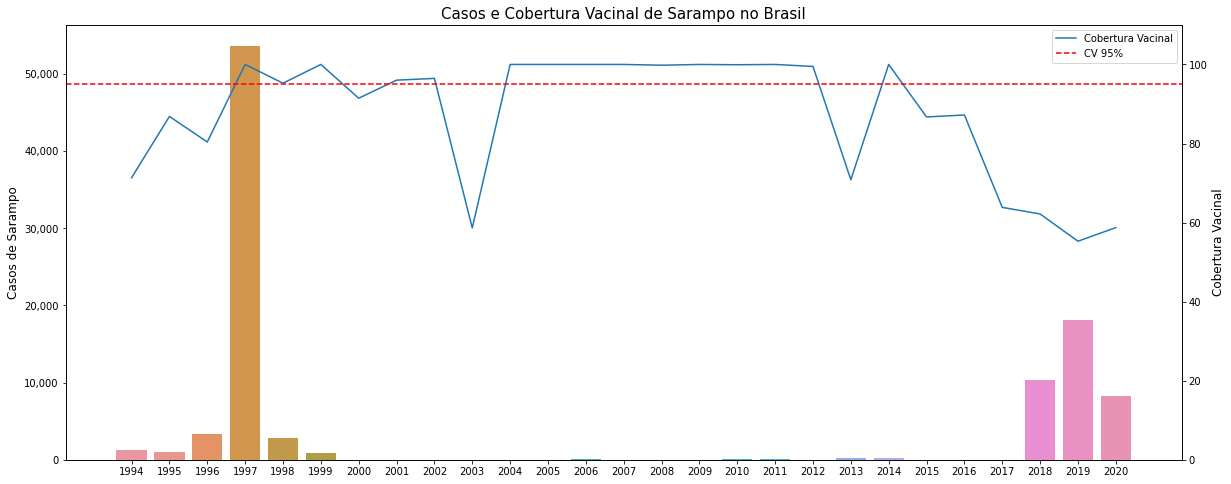

In [321]:
plt.figure(figsize=(20,8))

ax1 = sns.barplot(data=df_sarampo_casos_total_t[4:],x=df_sarampo_casos_total_t[4:].index,y=df_sarampo_casos_total_t[4:]['Total'])
ax2 = ax1.twinx()
color = 'tab:blue'
ax2 = sns.lineplot(data=df_sarampo_cob_nac_t,x=df_sarampo_cob_nac_t.index,y=df_sarampo_cob_nac_t['Total'], label='Cobertura Vacinal')

# marcar o threshold mínimo para uma cobertura vacinal eficaz
ax2.axhline(y = 95, linestyle = '--', color = 'red', label='CV 95%')
ax2.set(ylim=(0, 110))

ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Casos e Cobertura Vacinal de Sarampo no Brasil',fontsize=15)
ax1.set_ylabel("Casos de Sarampo",fontsize=12)
ax2.set_ylabel("Cobertura Vacinal",fontsize=12)

plt.legend()
plt.show()

Após mais de uma década sem registrar casos de forma expressiva, temos a volta do sarampo em 2018:

*O vírus voltou ao Brasil [em 2018] com os refugiados que vieram da Venezuela, mas, a partir do momento em que as pessoas passaram a transmitir o vírus de uma para a outra dentro do país, os casos de sarampo deixaram de ser importados e passaram a ser autóctones.*

Fonte: https://noticias.r7.com/saude/numero-de-casos-de-sarampo-no-brasil-e-o-maior-em-20-anos-03082018 

## Entrando no detalhe dos anos com maior número de casos

### Surto de 1997

Olhando incialmente para o ano de 1996, vemos que o sarampo estava presente em vários estados.

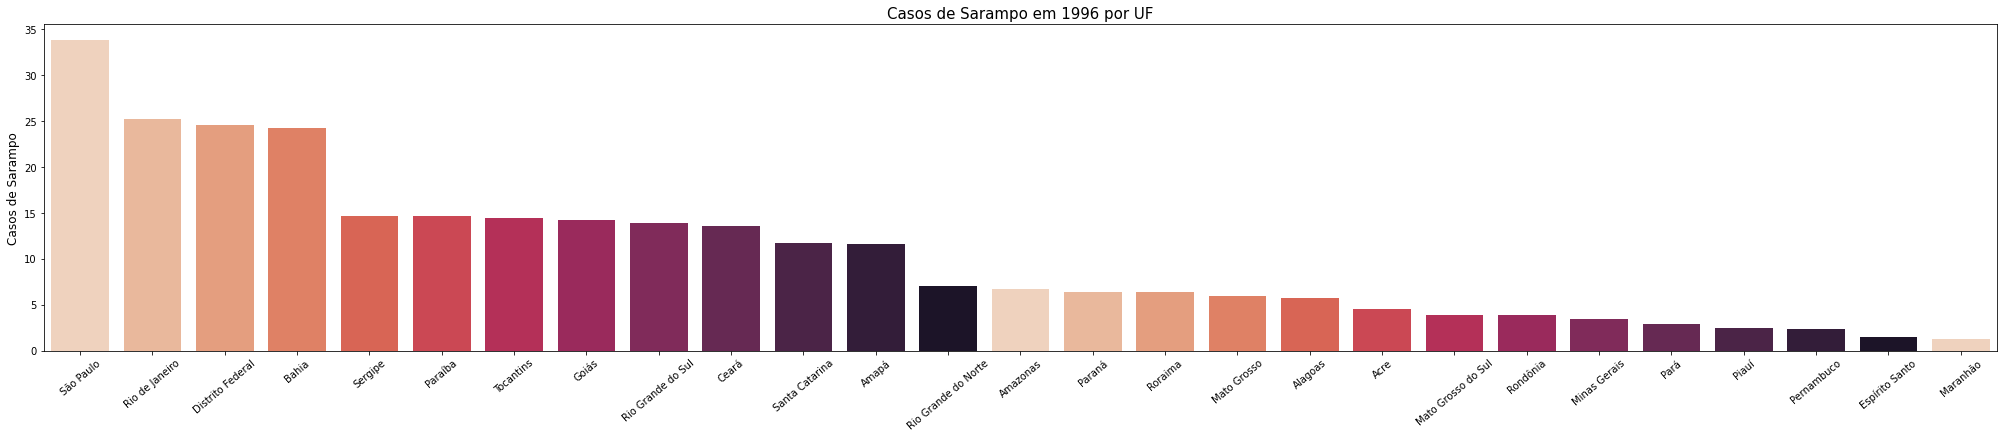

In [322]:
df_sarampo_casos = df_sarampo_casos.sort_values('1996',ascending = False)

plt.figure(figsize=(35,6))
plt.xticks(rotation = 40)

ax = sns.barplot(data=df_sarampo_casos,x=df_sarampo_casos.index,y=df_sarampo_casos['1996'],palette=sns.color_palette('rocket_r',13))

plt.title('Casos de Sarampo em 1996 por UF',fontsize=15)
ax.set_ylabel("Casos de Sarampo",fontsize=12)

plt.show()

 Porém, se colocado na escala do surto de 1997, podemos ver que o ano de 1996 foi bem menos expressivo que a principio parecia ser.

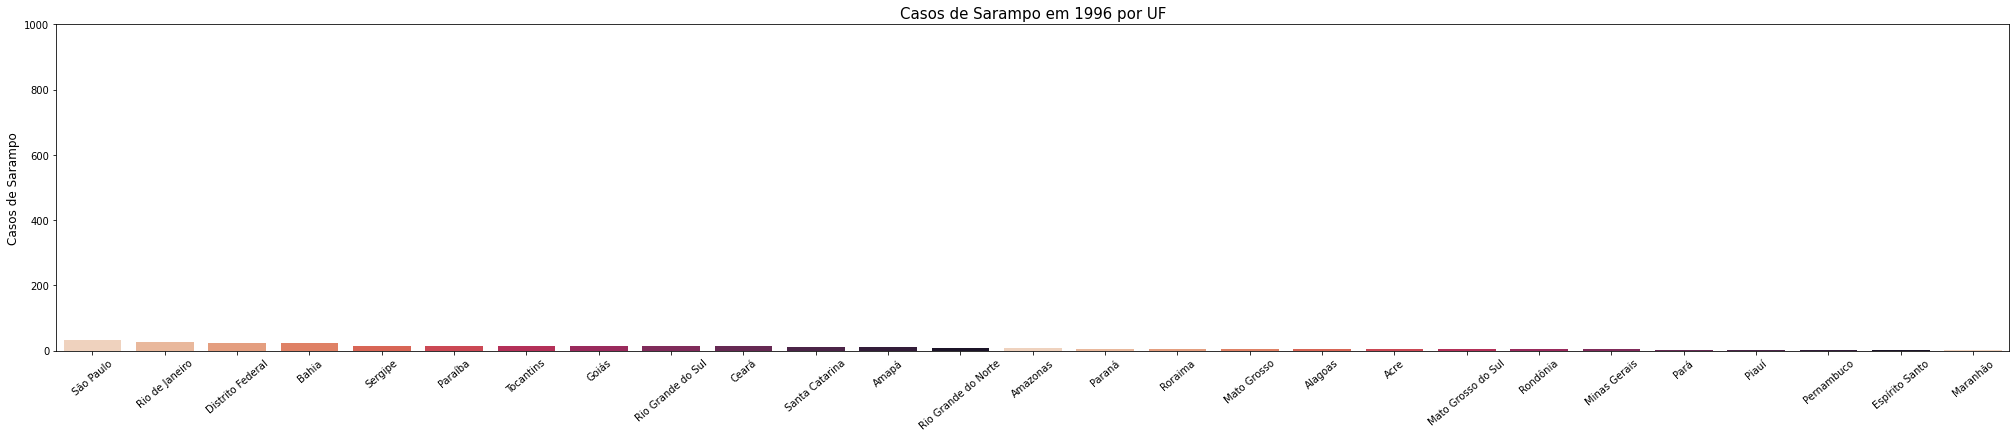

In [323]:
df_sarampo_casos = df_sarampo_casos.sort_values('1996',ascending = False)

plt.figure(figsize=(35,6))
plt.xticks(rotation = 40)

ax = sns.barplot(data=df_sarampo_casos,x=df_sarampo_casos.index,y=df_sarampo_casos['1996'],palette=sns.color_palette('rocket_r',13))
ax.set(ylim=(0, 1000))

plt.title('Casos de Sarampo em 1996 por UF',fontsize=15)
ax.set_ylabel("Casos de Sarampo",fontsize=12)

plt.show()

No ano de 2017, o ano da grande epidemia de sarampo, São Paulo apresenta mais que 3x o número de casos por milhão de habitantes, se comparado com o segundo lugar, o Distrito Federal. Por ser destino de muita migração interna, com um fluxo urbano de pessoas muito maior que o dos outros estados, São Paulo acabou sendo mais impactado que o restante do Brasil.

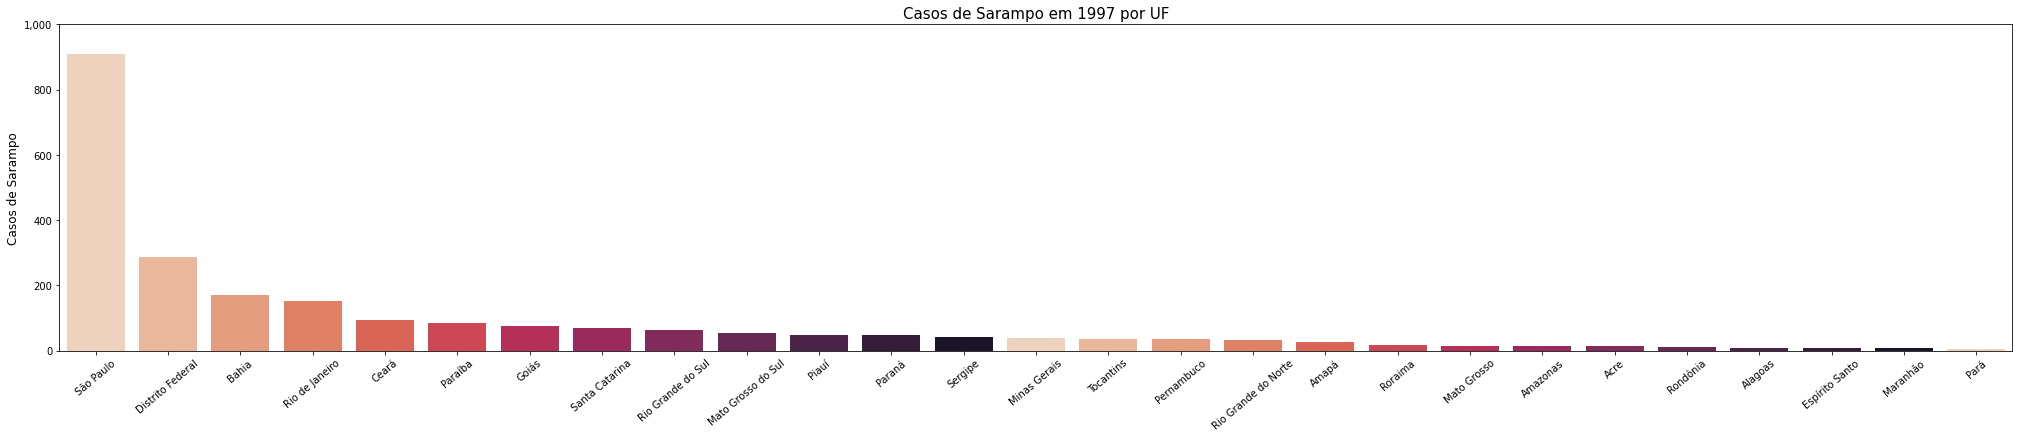

In [324]:
df_sarampo_casos = df_sarampo_casos.sort_values('1997',ascending = False)

plt.figure(figsize=(35,6))
plt.xticks(rotation = 40)

ax = sns.barplot(data=df_sarampo_casos,x=df_sarampo_casos.index,y=df_sarampo_casos['1997'],palette=sns.color_palette('rocket_r',13))
ax.set(ylim=(0, 1000))

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Casos de Sarampo em 1997 por UF',fontsize=15)
ax.set_ylabel("Casos de Sarampo",fontsize=12)

plt.show()

### Surto de 2018

Porém, analisando o surto mais recente, que começou em 2018, podemos ver bem o efeito citado anteriormente da migração Venezuelana, já que os estados com maior índice de casos por milhão de habitantes são três estados da Região Norte.

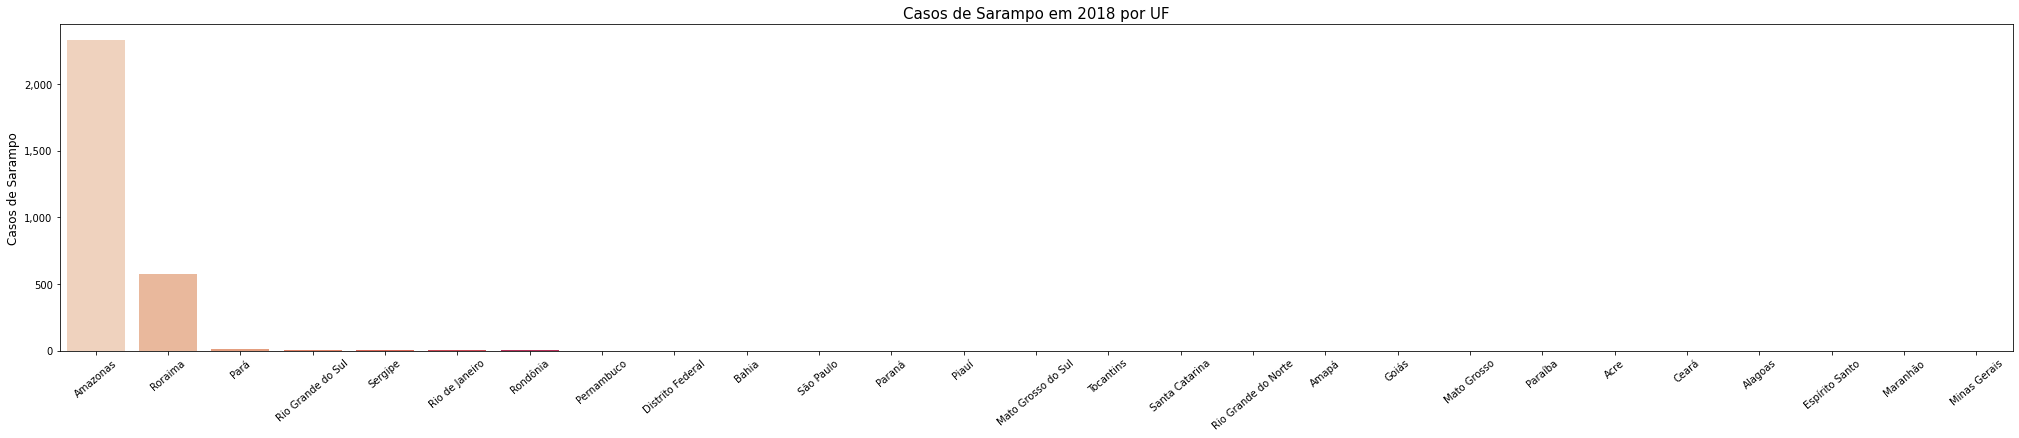

In [325]:
df_sarampo_casos = df_sarampo_casos.sort_values('2018',ascending = False)

plt.figure(figsize=(35,6))
plt.xticks(rotation = 40)
ax = sns.barplot(data=df_sarampo_casos,x=df_sarampo_casos.index,y=df_sarampo_casos['2018'],palette=sns.color_palette('rocket_r',13))

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Casos de Sarampo em 2018 por UF',fontsize=15)
ax.set_ylabel("Casos de Sarampo",fontsize=12)

plt.show()

Porém, novamente vemos o efeito de São Paulo ter o maior fluxo de pessoas do país, e a maior população, o que fez o estado disparar em casos por mihlão de habitantes, se comparado com os outros estados.

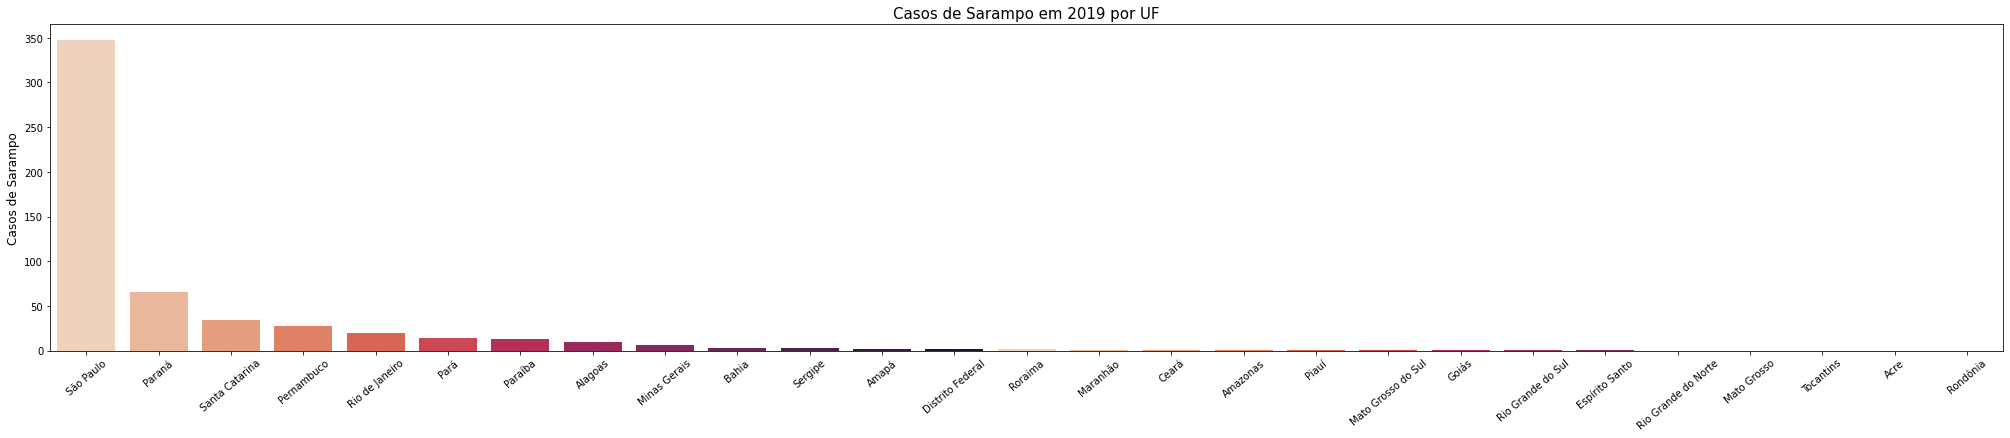

In [326]:
df_sarampo_casos = df_sarampo_casos.sort_values('2019',ascending = False)

plt.figure(figsize=(35,6))
plt.xticks(rotation = 40)
ax = sns.barplot(data=df_sarampo_casos,x=df_sarampo_casos.index,y=df_sarampo_casos['2019'],palette=sns.color_palette('rocket_r',13))

plt.title('Casos de Sarampo em 2019 por UF',fontsize=15)
ax.set_ylabel("Casos de Sarampo",fontsize=12)

plt.show()

## Relação do Número de Casos Totais com Cobertura Vacinal

Analisando os dois períodos críticos, 1994-1998 e 2017-2019, vemos que a Cobertura Vacinal tem impacto no número de casos, sendo que o acúmulo dela abaixo dos 95% ao longo dos anos faz com que um surto seja muito provável nos anos seguintes, como é o caso do surto de 1997 e do surto de 2019.

Podemos ver que, após uma ação mais incisiva de imunização ,fazendo com que a cobertura vacinal chegasse no patamar de 95%, o surto de 1997 fosse controlado.

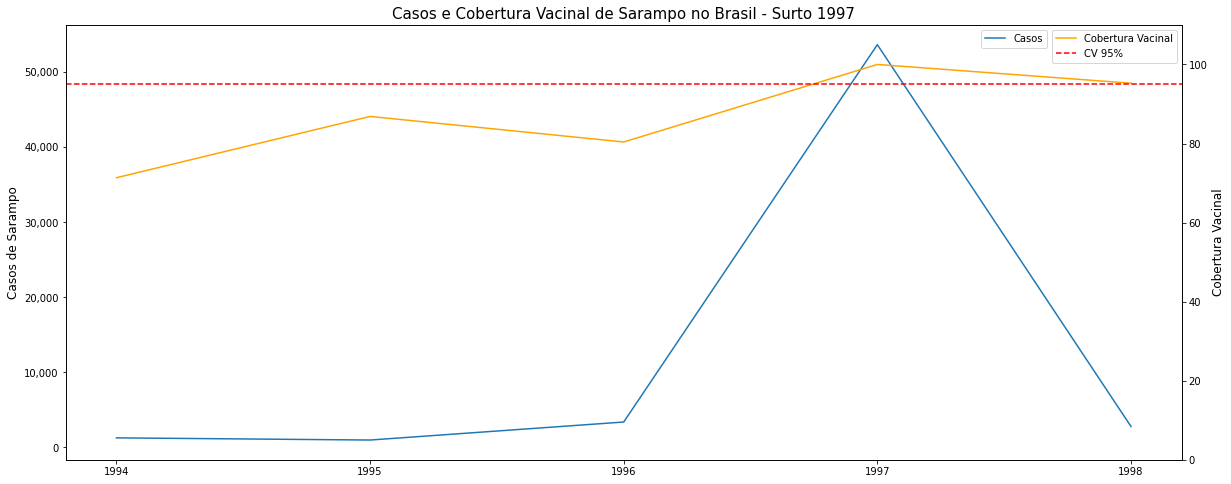

In [327]:
plt.figure(figsize=(20,8))

ax1 = sns.lineplot(data=df_sarampo_casos_total_t[4:9],x=df_sarampo_casos_total_t[4:9].index,y=df_sarampo_casos_total_t[4:9]['Total'],label='Casos')
ax2 = ax1.twinx()
ax2 = sns.lineplot(data=df_sarampo_cob_nac_t[:5],x=df_sarampo_cob_nac_t[:5].index,y=df_sarampo_cob_nac_t[:5]['Total'], color='orange',label='Cobertura Vacinal')

# marcar o threshold mínimo para uma cobertura vacinal eficaz
ax2.axhline(y = 95, linestyle = '--', color = 'red',label='CV 95%')
ax2.set(ylim=(0, 110))

ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Casos e Cobertura Vacinal de Sarampo no Brasil - Surto 1997',fontsize=15)
ax1.set_ylabel("Casos de Sarampo",fontsize=12)
ax2.set_ylabel("Cobertura Vacinal",fontsize=12)

ax1.legend(loc='upper left', bbox_to_anchor=(0.816, 0.5, 0.5, 0.5))
plt.legend()
plt.show()

Quanto ao surto de 2019, vemos que a tendência é de aumento, dado que a Cobertura Vacinal não se encontra nos patamares desejados de pelo menos 95%. O governo deveria promover uma campanha de conscientização e vacinação, para impedir que o surto cresça ainda mais. Porém, nota-se que o surto de 2019 está muito longe em questão da dimensão dele do surto de 1997, sendo a situação bem menos alarmante.

O surto provavelmente não foi efetivamente controlado porque a taxa de cobertura vacinal vêm caindo ao longo dos anos, o que, junto com a chegada de imigrantes venezuelanos no Norte, fez com que o número de casos subisse.

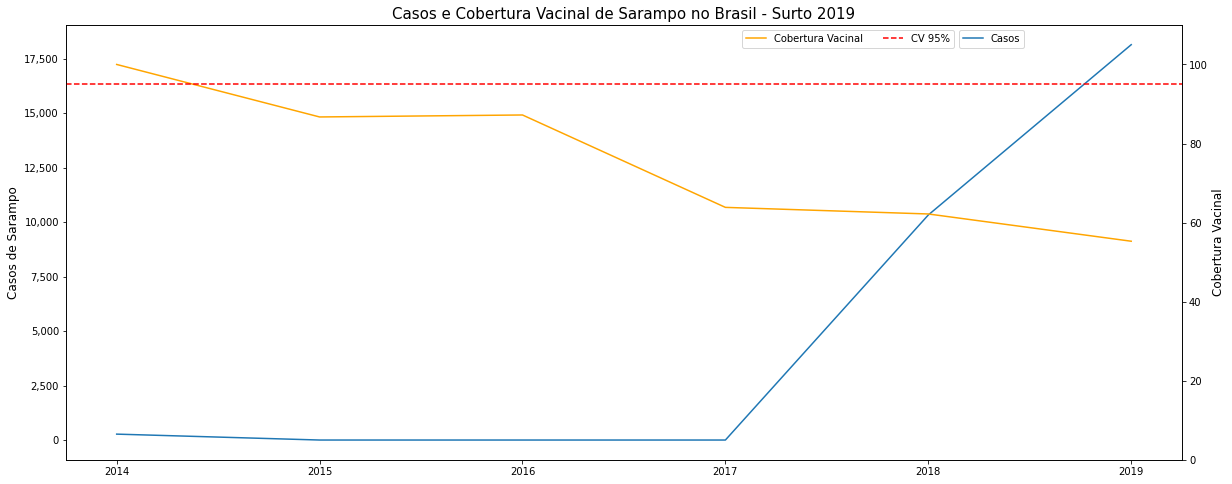

In [328]:
plt.figure(figsize=(20,8))

ax1 = sns.lineplot(data=df_sarampo_casos_total_t[-7:-1],x=df_sarampo_casos_total_t[-7:-1].index,y=df_sarampo_casos_total_t[-7:-1]['Total'],label='Casos')
ax2 = ax1.twinx()
ax2 = sns.lineplot(data=df_sarampo_cob_nac_t[-7:-1],x=df_sarampo_cob_nac_t[-7:-1].index,y=df_sarampo_cob_nac_t[-7:-1]['Total'], color='orange',label='Cobertura Vacinal')

# marcar o threshold mínimo para uma cobertura vacinal eficaz
ax2.axhline(y = 95, linestyle = '--', color = 'red',label='CV 95%')
ax2.set(ylim=(0, 110))

ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Casos e Cobertura Vacinal de Sarampo no Brasil - Surto 2019',fontsize=15)
ax1.set_ylabel("Casos de Sarampo",fontsize=12)
ax2.set_ylabel("Cobertura Vacinal",fontsize=12)

ax1.legend(bbox_to_anchor=(0.363, 0.5, 0.5, 0.5))
ax2.legend(bbox_to_anchor=(0.3, 0.5, 0.5, 0.5),ncol=2)
plt.show()

### Regressão Prep

In [329]:
# criando df de casos e cobertura vacinal por ano e uf

df_cob_melt = df_sarampo_cob_t.copy()
df_cob_melt = df_cob_melt.reset_index().melt(id_vars=['index'],value_vars=df_cob_melt.columns)
df_cob_melt.columns = ['ano','uf','cobertura_vacinal']
df_cob_melt['join_key'] = df_cob_melt['ano'] + df_cob_melt['uf']
df_cob_melt.index = df_cob_melt['join_key']
df_cob_melt = df_cob_melt.drop(columns=['uf','ano','join_key'])


df_casos_melt = df_sarampo_casos_t.copy()
df_casos_melt = df_casos_melt.reset_index().melt(id_vars=['index'],value_vars=df_casos_melt.columns)
df_casos_melt.columns = ['ano','uf','casos']
df_casos_melt['join_key'] = df_casos_melt['ano'] + df_casos_melt['uf']
df_casos_melt.index = df_casos_melt['join_key']
df_casos_melt = df_casos_melt.drop(columns=['uf','ano','join_key'])

df_uf_comparison = df_casos_melt.merge(df_cob_melt,left_index=True,right_index=True)
df_uf_comparison = df_uf_comparison[df_uf_comparison['cobertura_vacinal']>=30]
df_uf_comparison.head()

,casos,cobertura_vacinal
join_key,,
1994Rondônia,19.482761,75.57
1995Rondônia,12.802957,96.54
1996Rondônia,3.896552,82.64
1997Rondônia,9.463055,100.00
1998Rondônia,12.246307,100.00


In [330]:
# df jutando dados Nacionais de casos e cobertura vacinal

df_total_comparison_2 = df_sarampo_cob_nac_t.copy()
df_total_comparison_2 = df_total_comparison_2['Total'].to_frame()
df_total_comparison_2.columns = ['cobertura vacinal']

df_total_comparison = df_sarampo_casos_total_t.copy()
df_total_comparison = df_total_comparison['Total'].to_frame()
df_total_comparison.columns = ['casos']
df_total_comparison = df_total_comparison[4:]

df_total_comparison = df_total_comparison.merge(df_total_comparison_2,left_index=True,right_index=True)
df_total_comparison.head()

,casos,cobertura vacinal
1994,1262,71.35
1995,972,86.85
1996,3372,80.39
1997,53664,100.00
1998,2781,95.26


### Regressão OLS

Vamos usar a regressão OLS, uma regressão linear, para analisar a hipótese de se a cobertura vacinal tem alguma correlação com os casos de sarampo.

#### Nacional

Como os casos apresentam uma variância muito grande, pois como a doença se manifesta em surtos, ao invés de ser uma doença perene e constante ao longo dos anos, as regressões lineares não serão adequadas aos dados. Para tanto, usaremos uma transformação logística do eixo y, ou seja, do número de casos, para que a variância seja menor e mais controlada.

In [331]:
x = df_total_comparison['cobertura vacinal']
y = df_total_comparison['casos']

x = sm.add_constant(df_total_comparison['cobertura vacinal'])
model = sm.OLS(y, x).fit()
predictions = model.predict(x) # make the predictions by the model

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  casos   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.2181
Date:                Sat, 05 Dec 2020   Prob (F-statistic):              0.645
Time:                        22:13:47   Log-Likelihood:                -288.44
No. Observations:                  27   AIC:                             580.9
Df Residuals:                      25   BIC:                             583.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              9239.7169    1.2e+04      0.769      0.449   -1.55e+04     3.4e+04
cobertura vacinal   -63.1636    135.261     -0.467      0.645    -341.738     215.411
==============================================================================
Omnibus:                       57.373   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              398.055
Skew:                           4.152   Prob(JB):                     3.66e-87
Kurtosis:                      19.878   Cond. No.                         505.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

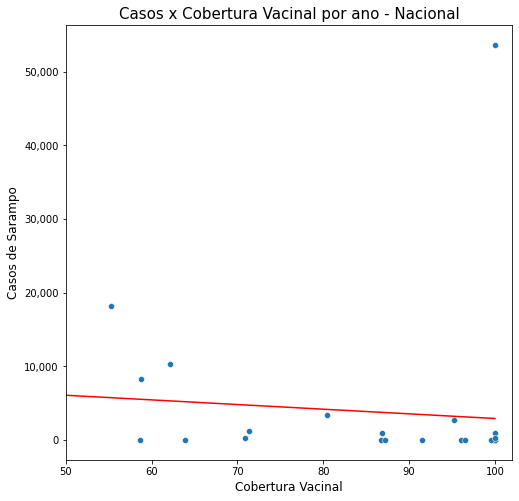

In [332]:
plt.figure(figsize=[8, 8])

ax = sns.scatterplot(data=df_total_comparison,y=df_total_comparison['casos'],x=df_total_comparison['cobertura vacinal'])

const = model.params['const']
cob_vacin = model.params['cobertura vacinal']

X_plot = np.linspace(0, 100)
Y_plot = cob_vacin*X_plot+const

plt.plot(X_plot, Y_plot, color='r')

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Casos x Cobertura Vacinal por ano - Nacional',fontsize=15)
ax.set_ylabel("Casos de Sarampo",fontsize=12)
ax.set_xlabel("Cobertura Vacinal",fontsize=12)

ax.set(xlim=(50,102))

plt.show()

In [333]:
x = df_total_comparison['cobertura vacinal']
y = np.log(df_total_comparison['casos']+1)

x = sm.add_constant(df_total_comparison['cobertura vacinal'])
model = sm.OLS(y, x).fit()
predictions = model.predict(x) # make the predictions by the model

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  casos   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     3.411
Date:                Sat, 05 Dec 2020   Prob (F-statistic):             0.0766
Time:                        22:13:48   Log-Likelihood:                -70.952
No. Observations:                  27   AIC:                             145.9
Df Residuals:                      25   BIC:                             148.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                10.9673      3.813      2.876      0.008       3.114      18.820
cobertura vacinal    -0.0793      0.043     -1.847      0.077      -0.168       0.009
==============================================================================
Omnibus:                        0.609   Durbin-Watson:                   0.805
Prob(Omnibus):                  0.738   Jarque-Bera (JB):                0.684
Skew:                           0.184   Prob(JB):                        0.710
Kurtosis:                       2.312   Cond. No.                         505.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

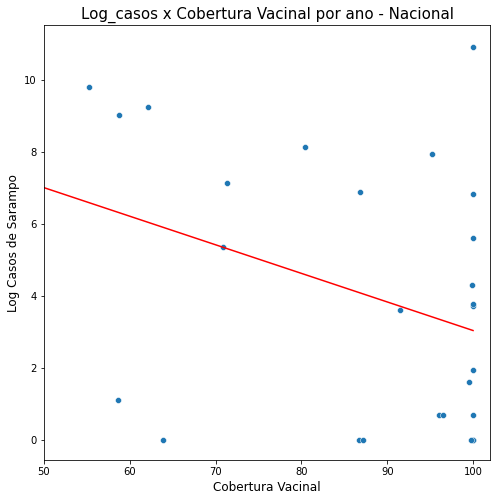

In [334]:
plt.figure(figsize=[8, 8])

y = np.log(df_total_comparison['casos']+1)
ax = sns.scatterplot(data=df_total_comparison,y=y,x=df_total_comparison['cobertura vacinal'])

const = model.params['const']
cob_vacin = model.params['cobertura vacinal']

X_plot = np.linspace(0, 100)
Y_plot = cob_vacin*X_plot+const

plt.plot(X_plot, Y_plot, color='r')

plt.title('Log_casos x Cobertura Vacinal por ano - Nacional',fontsize=15)
ax.set_ylabel("Log Casos de Sarampo",fontsize=12)
ax.set_xlabel("Cobertura Vacinal",fontsize=12)

ax.set(xlim=(50,102))

plt.show()

Podemos ver que, tanto no caso com a transformação logística como no caso base, o R² é muito baixo, e o coeficiente da cobertura vacinal não se mostrou significativo. Logo, precisariamos de mais dados ou outra variáveis para chegar em uma modelagem mais precisa para o caso de previsão dos casos de sarampo.

---



#### Dados por UF

Para a análise com os dados por UF, encontra-se o mesmo problema da variância dos casos, mesmo que estes sejam normalizados, já que são casos por milhão de habitantes. Para tanto, usaremos a mesma transformação logística.

In [335]:
x = df_uf_comparison['cobertura_vacinal']
y = df_uf_comparison['casos']

x = sm.add_constant(df_uf_comparison['cobertura_vacinal'])
model = sm.OLS(y, x).fit()
predictions = model.predict(x) # make the predictions by the model

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  casos   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8694
Date:                Sat, 05 Dec 2020   Prob (F-statistic):              0.351
Time:                        22:13:48   Log-Likelihood:                -4279.3
No. Observations:                 710   AIC:                             8563.
Df Residuals:                     708   BIC:                             8572.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                28.3625     19.262      1.472      0.141      -9.455      66.180
cobertura_vacinal    -0.2054      0.220     -0.932      0.351      -0.638       0.227
==============================================================================
Omnibus:                     1596.884   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5023484.034
Skew:                          18.984   Prob(JB):                         0.00
Kurtosis:                     413.325   Cond. No.                         447.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

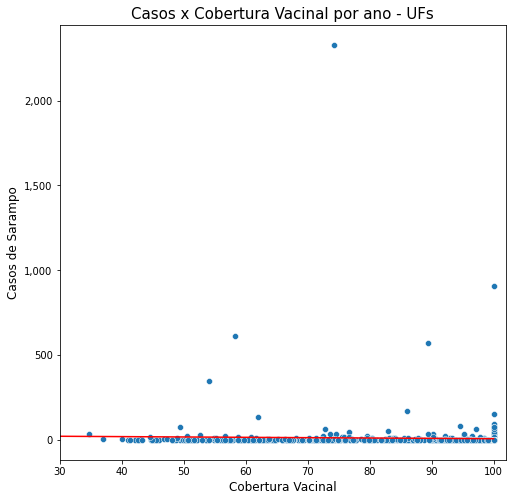

In [336]:
plt.figure(figsize=[8, 8])

ax = sns.scatterplot(data=df_uf_comparison,y=df_uf_comparison['casos'],x=df_uf_comparison['cobertura_vacinal'])

const = model.params['const']
cob_vacin = model.params['cobertura_vacinal']

X_plot = np.linspace(0, 100)
Y_plot = cob_vacin*X_plot+const

plt.plot(X_plot, Y_plot, color='r')

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Casos x Cobertura Vacinal por ano - UFs',fontsize=15)
ax.set_ylabel("Casos de Sarampo",fontsize=12)
ax.set_xlabel("Cobertura Vacinal",fontsize=12)

ax.set(xlim=(30,102))

plt.show()

In [337]:
x = df_uf_comparison['cobertura_vacinal']
y = np.log(df_uf_comparison['casos']+1)

x = sm.add_constant(df_uf_comparison['cobertura_vacinal'])
model = sm.OLS(y, x).fit()
predictions = model.predict(x) # make the predictions by the model

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  casos   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     10.30
Date:                Sat, 05 Dec 2020   Prob (F-statistic):            0.00139
Time:                        22:13:48   Log-Likelihood:                -1130.3
No. Observations:                 710   AIC:                             2265.
Df Residuals:                     708   BIC:                             2274.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.3364      0.228      5.853      0.000       0.888       1.785
cobertura_vacinal    -0.0084      0.003     -3.210      0.001      -0.014      -0.003
==============================================================================
Omnibus:                      346.072   Durbin-Watson:                   0.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1573.281
Skew:                           2.292   Prob(JB):                         0.00
Kurtosis:                       8.671   Cond. No.                         447.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

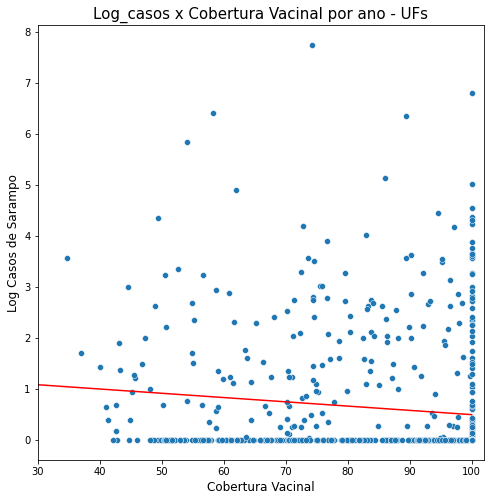

In [338]:
plt.figure(figsize=[8, 8])

y = np.log(df_uf_comparison['casos']+1)
ax = sns.scatterplot(data=df_uf_comparison,y=y,x=df_uf_comparison['cobertura_vacinal'])

const = model.params['const']
cob_vacin = model.params['cobertura_vacinal']

X_plot = np.linspace(0, 100)
Y_plot = cob_vacin*X_plot+const

plt.plot(X_plot, Y_plot, color='r')

plt.title('Casos x Cobertura Vacinal por ano - UFs',fontsize=15)
ax.set_ylabel("Casos de Sarampo",fontsize=12)
ax.set_xlabel("Cobertura Vacinal",fontsize=12)

ax.set(xlim=(30,102))

plt.title('Log_casos x Cobertura Vacinal por ano - UFs',fontsize=15)
ax.set_ylabel("Log Casos de Sarampo",fontsize=12)
ax.set_xlabel("Cobertura Vacinal",fontsize=12)

plt.show()

Neste cenário, chegamos à um modelo mais satisfatório, que seria o com a transformação logística dos casos por milhão de habitantes. Como os coeficientes se mostraram significantes, podemos concluir que o intercepto é positivo, e que o coeficiente da variável x é negativo, mostrando assim uma reta descendente. Mesmo os coeficientes sendo estatisticamente diferente de zero, o R² é muito baixo, um reflexo da alta dispersão dos pontos. Logo, somente a cobertura vacinal não parece ser um preditor suficiente para os número de casos. Outras variáveis deveriam ser incluídas para se chegar no modelo ideal.

## Conclusão

O sarampo é uma doença que assolou por muito tempo o Brasil, mas que também é uma história de sucesso quando pensamos na eficácia das campanhas de vacinação. Através de campanhas bem sucedidas, os casos de sarampo foram praticamente zerados por mais de uma década. Porém, com a queda da cobertura vacinal para abaixo do patamar de 95%, considerado como o ideal, o número de casos tem aumentado, e agora o Brasil se depara com mais um surto, iniciado em 2018.

O escopo da análise era entender como os casos de sarampo oscilaram ao longo dos anos, tanto do ponto de vista nacional como do ponto de vista dos Estados mais afetados pelo sarampo, e verificar a existência de uma relação entre a cobertura vacinal e o número de casos.

Observando os dados e os gráficos, podemos ver que a cobertura vacinal tem um papel muito importante em mitigar e impedir novos surtos de Sarampo. O país passou por mais de uma década de um grande controle de casos, sendo que vários anos não reportou nenhum caso. Porém, com o influxo de venezuelanos no Norte do país, aliado à falta sistêmica de cobertura vacinal desde 2014 (último ano com patamar acima de 95%), fez com que a situação dos casos deixa-se de estar sob controle, e um novo surto fosse possível.

Como os dados de 2020 estão incompletos, ainda não conseguimos afirmar se o surto foi controlado, ou se veremos ainda casos de Sarampo em 2021. Com novos dados,e o fim do surto, poderíamos ter uma visão mais específica e melhor mapeada do Sarampo neste surto de 2019.